In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 데이터 분할(폴더) 구분
data_splits = ["train", "test"]

# 각 데이터 유형별 폴더명, 파일 접미사, 변수 접두어 설정
data_categories = {
    "회원정보": {"folder": "1.회원정보", "suffix": "회원정보", "var_prefix": "customer"}
}


for split in data_splits:
    for category, info in data_categories.items():
        folder = info["folder"]
        suffix = info["suffix"]
        var_prefix = info["var_prefix"]
        
        file_path = f"./data/{folder}/{split}_{suffix}.parquet"
        # 변수명 형식: {var_prefix}_{split}_{month}
        variable_name = f"{var_prefix}_{split}"
        globals()[variable_name] = pd.read_parquet(file_path, engine="pyarrow")
        print(f"{variable_name} is loaded from {file_path}")

gc.collect()

customer_train is loaded from ./data/1.회원정보/train_회원정보.parquet
customer_test is loaded from ./data/1.회원정보/test_회원정보.parquet


0

In [3]:
# 데이터 유형별 설정 
info_categories = ["customer"]
#### Train ####

# 각 유형별로 월별 데이터를 합쳐서 새로운 변수에 저장
train_dfs = {}

for prefix in info_categories:
    # globals()에서 동적 변수명으로 데이터프레임들을 가져와 리스트에 저장
    df_list = [globals()[f"{prefix}_train"]]
    train_dfs[f"{prefix}_train_df"] = pd.concat(df_list, axis=0)
    gc.collect()
    print(f"{prefix}_train_df is created with shape: {train_dfs[f'{prefix}_train_df'].shape}")

customer_train_df = train_dfs["customer_train_df"]

customer_train_df is created with shape: (400000, 78)


In [4]:

# 각 유형별로 월별 데이터를 합쳐서 새로운 변수에 저장
test_dfs = {}

for prefix in info_categories:
    # globals()에서 동적 변수명으로 데이터프레임들을 가져와 리스트에 저장
    df_list = [globals()[f"{prefix}_test"]]
    test_dfs[f"{prefix}_test_df"] = pd.concat(df_list, axis=0)
    gc.collect()
    print(f"{prefix}_test_df is created with shape: {test_dfs[f'{prefix}_test_df'].shape}")

customer_test_df = test_dfs["customer_test_df"]

customer_test_df is created with shape: (100000, 77)


In [5]:
customer_train_df.head()

,기준년월,ID,남녀구분코드,연령,Segment,회원여부_이용가능,회원여부_이용가능_CA,회원여부_이용가능_카드론,소지여부_신용,소지카드수_유효_신용,...,할인금액_제휴연회비_B0M,청구금액_기본연회비_B0M,청구금액_제휴연회비_B0M,상품관련면제카드수_B0M,임직원면제카드수_B0M,우수회원면제카드수_B0M,기타면제카드수_B0M,카드신청건수,Life_Stage,최종카드발급경과월
0,201811,TRAIN_000000,2,40대,D,1,1,0,1,1,...,0,0,0,0개,0개,0개,0개,0,자녀성장(2),26
1,201811,TRAIN_000001,1,30대,E,1,1,1,1,1,...,0,0,0,0개,0개,0개,0개,0,자녀성장(1),22
2,201811,TRAIN_000002,1,30대,C,1,1,0,1,1,...,0,0,0,0개,0개,0개,0개,0,자녀출산기,24
3,201811,TRAIN_000003,2,40대,D,1,1,0,1,2,...,0,0,0,0개,0개,0개,0개,1,자녀성장(2),21
4,201811,TRAIN_000004,2,40대,E,1,1,1,1,1,...,0,0,0,0개,0개,0개,0개,0,자녀성장(1),19


Segment
E    320342
D     58207
C     21265
A       162
B        24
Name: count, dtype: int64

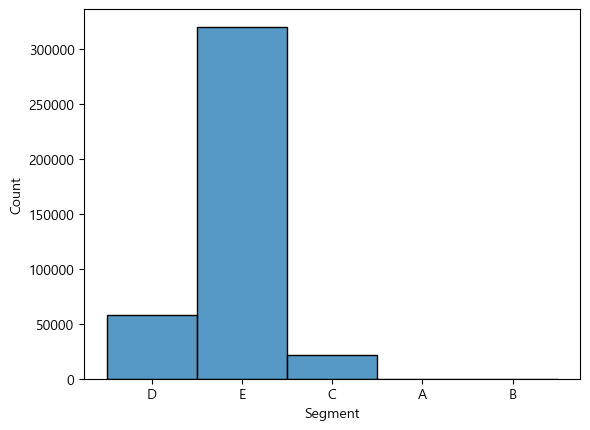

In [6]:
y = customer_train_df['Segment']
sns.histplot(y)
y.value_counts()

In [7]:
X = customer_train_df.drop(columns=['Segment'])
X.head()

,기준년월,ID,남녀구분코드,연령,회원여부_이용가능,회원여부_이용가능_CA,회원여부_이용가능_카드론,소지여부_신용,소지카드수_유효_신용,소지카드수_이용가능_신용,...,할인금액_제휴연회비_B0M,청구금액_기본연회비_B0M,청구금액_제휴연회비_B0M,상품관련면제카드수_B0M,임직원면제카드수_B0M,우수회원면제카드수_B0M,기타면제카드수_B0M,카드신청건수,Life_Stage,최종카드발급경과월
0,201811,TRAIN_000000,2,40대,1,1,0,1,1,1,...,0,0,0,0개,0개,0개,0개,0,자녀성장(2),26
1,201811,TRAIN_000001,1,30대,1,1,1,1,1,1,...,0,0,0,0개,0개,0개,0개,0,자녀성장(1),22
2,201811,TRAIN_000002,1,30대,1,1,0,1,1,1,...,0,0,0,0개,0개,0개,0개,0,자녀출산기,24
3,201811,TRAIN_000003,2,40대,1,1,0,1,2,2,...,0,0,0,0개,0개,0개,0개,1,자녀성장(2),21
4,201811,TRAIN_000004,2,40대,1,1,1,1,1,1,...,0,0,0,0개,0개,0개,0개,0,자녀성장(1),19


# 연속형, 범주형 데이터 구분

In [8]:
continuous_cols = []
categorical_cols = []
var_0_cols = []
for col in X.loc[:, "남녀구분코드":].columns:
    # print("===", col, "==================================================")
    # print(len(X[col].unique()))
    unique_num = len(X[col].unique())
    if unique_num == 1:
        var_0_cols.append(col)
    elif unique_num < 50:
        categorical_cols.append(col)
    else:
        continuous_cols.append(col)
    # print(X[col].unique())
    # print()
print()
print("<==== to drop cols ====>")
print(len(var_0_cols), *var_0_cols)


<==== to drop cols ====>
9 이용카드수_체크_가족 이용금액_R3M_체크_가족 연회비할인카드수_B0M 할인금액_기본연회비_B0M 할인금액_제휴연회비_B0M 상품관련면제카드수_B0M 임직원면제카드수_B0M 우수회원면제카드수_B0M 기타면제카드수_B0M


- 모든 행이 같은 수임 -> 의미가 없기 때문에 제거함

In [9]:
print(len(continuous_cols))
print(len(categorical_cols))

15
51


In [10]:
test = customer_test_df.copy()

In [11]:
for col in categorical_cols:
    print("===", col, "==================================================")
    print("train:", len(X[col].unique()))
    print("test:", len(test[col].unique()))
    print(X[col].unique())
    print(test[col].unique())
    print()   

=== 남녀구분코드 ==================================================
train: 2
test: 2
[2 1]
[1 2]

=== 연령 ==================================================
train: 6
test: 6
['40대' '30대' '20대' '60대' '50대' '70대이상']
['50대' '40대' '30대' '20대' '70대이상' '60대']

=== 회원여부_이용가능 ==================================================
train: 2
test: 2
[1 0]
[1 0]

=== 회원여부_이용가능_CA ==================================================
train: 2
test: 2
[1 0]
[1 0]

=== 회원여부_이용가능_카드론 ==================================================
train: 2
test: 2
[0 1]
[1 0]

=== 소지여부_신용 ==================================================
train: 2
test: 2
[1 0]
[1 0]

=== 소지카드수_유효_신용 ==================================================
train: 5
test: 5
[1 2 3 0 4]
[3 1 2 0 4]

=== 소지카드수_이용가능_신용 ==================================================
train: 4
test: 4
[1 2 3 0]
[3 1 2 0]

=== 회원여부_연체 ==================================================
train: 2
test: 2
[0 1]
[0 1]

=== 이용거절여부_카드론 ===========================================

`기본연회비_B0M`, `제휴연회비_B0M`, `청구금액_기본연회비_B0M`, `청구금액_제휴연회비_B0M`는 금액이 고정되어 있지만 비용을 의미하기 때문에 연속형 변수에 추가

In [12]:
categorical_cols.remove('기본연회비_B0M')
categorical_cols.remove('제휴연회비_B0M')
categorical_cols.remove('청구금액_기본연회비_B0M')
categorical_cols.remove('청구금액_제휴연회비_B0M')

continuous_cols.append('기본연회비_B0M')
continuous_cols.append('제휴연회비_B0M')
continuous_cols.append('청구금액_기본연회비_B0M')
continuous_cols.append('청구금액_제휴연회비_B0M')

In [13]:
for col in continuous_cols:
    print("===", col, "==================================================")
    print(len(X[col].unique()))
    print(X[col].unique())
    print()   

=== 입회일자_신용 ==================================================
325
[20130101 20170801 20080401 20160501 20180601 20141001 20081001 20070301
 20121001 20161201 20080801 20151001 20170301 20150701 20170601 20070901
 20180201 20080601 20111001 20140801 20120401 20170201 20160901 20120201
 19990901 20140501 20100101 20150201 20170501 20110601 20070701 19970101
 19990501 20141201 20060701 20030601 20061201 20090901 20060601 19951101
 20060201 20001101 20030901 20170401 20140701 20000401 20160701 19991001
 20161001 20180301 20120701 20180101 20130601 20150101 20121201 20111201
 19930601 19940601 20110701 20120901 20080901 20130501 20161101 19991201
 20160301 20011001 19970201 20111101 19971201 20040601 20140301 20100801
 19980701 20130301 20140401 20131101 20170101 20171001 20170901 20091001
 20141101 19990401 20100501 20171201 20030501 20100201 20150501 20110401
 19950601 20150401 20100701 20040701 20151201 20110101 20120501 20090101
 20151101 20160601 20160401 19970901 20010101 20130901 20

날짜와 관련된 피처들이 많음 -> 특정 날짜로부터의 경과일로 대체(그런데 이런 값들을 이미 반영한 피처들이 있기도 함)

# Categorical features

In [14]:
from scipy.stats import chi2_contingency

valid_cat_cols = []
col_p = []
for col in categorical_cols:
    cross = pd.crosstab(X[col], y)
    chi2, p, dof, expected = chi2_contingency(cross)
    col_p.append([p, col])
    if p < 0.05:
        valid_cat_cols.append(col)
col_p.sort()
col_p

[[0.0, 'Life_Stage'],
 [0.0, '_2순위신용체크구분'],
 [0.0, '가입통신회사코드'],
 [0.0, '거주시도명'],
 [0.0, '남녀구분코드'],
 [0.0, '보유여부_해외겸용_본인'],
 [0.0, '보유여부_해외겸용_신용_본인'],
 [0.0, '소지여부_신용'],
 [0.0, '소지카드수_유효_신용'],
 [0.0, '소지카드수_이용가능_신용'],
 [0.0, '수신거부여부_DM'],
 [0.0, '수신거부여부_SMS'],
 [0.0, '수신거부여부_TM'],
 [0.0, '수신거부여부_메일'],
 [0.0, '연령'],
 [0.0, '유효카드수_신용'],
 [0.0, '유효카드수_신용_가족'],
 [0.0, '유효카드수_신용체크'],
 [0.0, '유효카드수_체크'],
 [0.0, '이용가능여부_해외겸용_본인'],
 [0.0, '이용가능여부_해외겸용_신용_본인'],
 [0.0, '이용가능카드수_신용'],
 [0.0, '이용가능카드수_신용_가족'],
 [0.0, '이용가능카드수_신용체크'],
 [0.0, '이용가능카드수_체크'],
 [0.0, '이용여부_3M_해외겸용_본인'],
 [0.0, '이용여부_3M_해외겸용_신용_본인'],
 [0.0, '이용카드수_신용'],
 [0.0, '이용카드수_신용_가족'],
 [0.0, '이용카드수_신용체크'],
 [0.0, '이용카드수_체크'],
 [0.0, '직장시도명'],
 [0.0, '탈회횟수_누적'],
 [0.0, '회원여부_이용가능'],
 [0.0, '회원여부_이용가능_CA'],
 [1.1002526023752113e-228, '동의여부_한도증액안내'],
 [2.0067811430906837e-208, '마케팅동의여부'],
 [9.021988895348385e-193, '_1순위신용체크구분'],
 [1.076324559398688e-119, '이용거절여부_카드론'],
 [4.4898869471313036e-88, '탈회횟수_발급1년이내'],
 [8.593694834703935e-7

In [15]:
valid_cat_cols

['남녀구분코드',
 '연령',
 '회원여부_이용가능',
 '회원여부_이용가능_CA',
 '회원여부_이용가능_카드론',
 '소지여부_신용',
 '소지카드수_유효_신용',
 '소지카드수_이용가능_신용',
 '회원여부_연체',
 '이용거절여부_카드론',
 '동의여부_한도증액안내',
 '수신거부여부_TM',
 '수신거부여부_DM',
 '수신거부여부_메일',
 '수신거부여부_SMS',
 '가입통신회사코드',
 '탈회횟수_누적',
 '탈회횟수_발급6개월이내',
 '탈회횟수_발급1년이내',
 '거주시도명',
 '직장시도명',
 '마케팅동의여부',
 '유효카드수_신용체크',
 '유효카드수_신용',
 '유효카드수_신용_가족',
 '유효카드수_체크',
 '이용가능카드수_신용체크',
 '이용가능카드수_신용',
 '이용가능카드수_신용_가족',
 '이용가능카드수_체크',
 '이용카드수_신용체크',
 '이용카드수_신용',
 '이용카드수_신용_가족',
 '이용카드수_체크',
 '_1순위신용체크구분',
 '_2순위신용체크구분',
 '보유여부_해외겸용_본인',
 '이용가능여부_해외겸용_본인',
 '이용여부_3M_해외겸용_본인',
 '보유여부_해외겸용_신용_본인',
 '이용가능여부_해외겸용_신용_본인',
 '이용여부_3M_해외겸용_신용_본인',
 '연회비발생카드수_B0M',
 '카드신청건수',
 'Life_Stage']

In [16]:
X_cat = X[valid_cat_cols]
missing_percentage = (X_cat.isnull().sum() / len(X_cat)) * 100

print("--- 훈련 데이터 컬럼별 결측치 비율 (%) ---")
print(missing_percentage[missing_percentage>0])

--- 훈련 데이터 컬럼별 결측치 비율 (%) ---
가입통신회사코드      15.81875
직장시도명         10.02800
_1순위신용체크구분     1.56025
_2순위신용체크구분    40.22375
dtype: float64


In [17]:
missing_percentage = (customer_test_df[valid_cat_cols].isnull().sum() / len(customer_test_df[valid_cat_cols])) * 100

print("--- 테스트 데이터 컬럼별 결측치 비율 (%) ---")
print(missing_percentage[missing_percentage>0])

--- 테스트 데이터 컬럼별 결측치 비율 (%) ---
가입통신회사코드      15.633
직장시도명         10.457
_1순위신용체크구분     1.816
_2순위신용체크구분    40.268
dtype: float64


`_2순위신용체크구분`은 결측치 비율이 너무 높아서 제거

In [18]:
X_cat_filled = X_cat.copy()

### _1순위신용체크구분(1.56%)

<Axes: xlabel='count', ylabel='_1순위신용체크구분'>

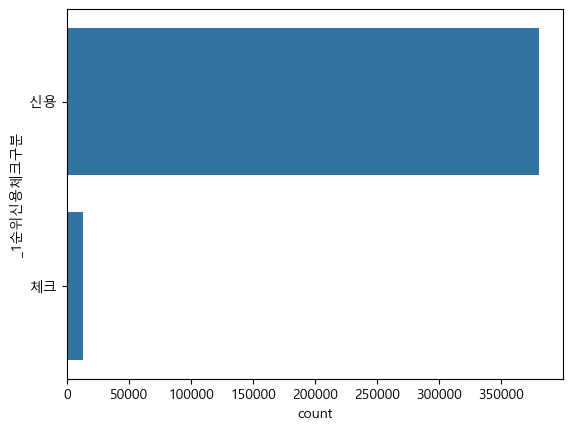

In [19]:
sns.countplot(X_cat["_1순위신용체크구분"])

결측치를 절대 다수인 `신용`으로 대체

In [20]:
X_cat_filled["_1순위신용체크구분"] = X_cat_filled["_1순위신용체크구분"].fillna("신용")

### 직장시도명(10.02%)

In [21]:
X_cat['직장시도명'].unique()

array(['서울', '경기', '부산', '강원', '대전', None, '인천', '경남', '광주', '충북', '전남',
       '경북', '울산', '전북', '세종', '대구', '충남', '제주'], dtype=object)

In [22]:
len(X_cat['직장시도명'].unique())

18

<Axes: xlabel='직장시도명', ylabel='count'>

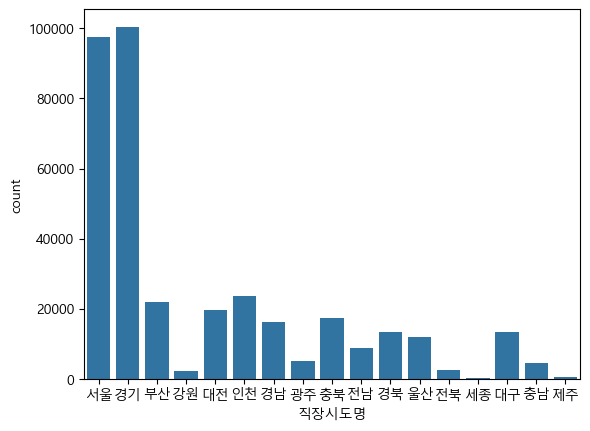

In [23]:
sns.countplot(data=X_cat, x="직장시도명")

In [24]:
a_b_ratio = []

for city in X_cat['직장시도명'].unique():
    if city == None:
        total = len(customer_train_df.loc[customer_train_df.직장시도명.isnull(), "Segment"])
        a_b = len(customer_train_df.loc[(customer_train_df.직장시도명.isnull()) & (customer_train_df.Segment == 'A')])
        ratio = a_b/total*100
        a_b_ratio.append([ratio, "None"])
        continue
    total = len(customer_train_df.loc[customer_train_df.직장시도명 == city, "Segment"])
    a_b = len(customer_train_df.loc[(customer_train_df.직장시도명 == city) & ((customer_train_df.Segment == 'A') | (customer_train_df.Segment == 'B'))])
    ratio = a_b/total*100
    a_b_ratio.append([ratio, city])
a_b_ratio.sort(reverse=True)
for r, city in a_b_ratio:
    print(city, r)

제주 0.21739130434782608
경기 0.07971938775510204
광주 0.0794754619511226
전북 0.07760962359332557
울산 0.049586776859504134
서울 0.04712776747569334
충남 0.04391743522178305
강원 0.04357298474945533
부산 0.04097987432838539
충북 0.04028081482333985
인천 0.0379794910748196
경북 0.037252272388615705
대전 0.02554278416347382
전남 0.022755717373990215
경남 0.018609267415172756
None 0.007479058635819704
대구 0.007380073800738008
세종 0.0


In [25]:
segment_ratio = {}

for city in X_cat['직장시도명'].unique():
    if city == None:
        segment_ratio["None"] = {}
        total = len(customer_train_df.loc[customer_train_df.직장시도명.isnull(), "Segment"])
        for segment in ['A', 'B', 'C', 'D', 'E']:
            segment_ratio["None"][segment] = len(customer_train_df.loc[(customer_train_df.직장시도명.isnull()) & (customer_train_df.Segment == segment)])/total*100
        segment_ratio["None"]['total'] = total
        continue
    segment_ratio[city] = {}
    total = len(customer_train_df.loc[customer_train_df.직장시도명 == city, "Segment"])
    for segment in ['A', 'B', 'C', 'D', 'E']:
        segment_ratio[city][segment] = len(customer_train_df.loc[(customer_train_df.직장시도명 == city) & (customer_train_df.Segment == segment)])/total*100
    segment_ratio[city]["total"] = total
a_ratio = []
b_ratio = []
c_ratio = []
d_ratio = []
e_ratio = []

for city in segment_ratio:
    ratio = segment_ratio[city]
    print(f"==== {city} ====")
    print(f"A: {round(ratio["A"], 6)}")
    print(f"B: {round(ratio["B"], 6)}")
    print(f"C: {round(ratio["C"], 6)}")
    print(f"D: {round(ratio["D"], 6)}")
    print(f"E: {round(ratio["E"], 6)}")
    print(f"total: {ratio["total"]}")
    a_ratio.append((round(ratio["A"], 6), city))
    b_ratio.append((round(ratio["B"], 6), city))
    c_ratio.append((round(ratio["C"], 6), city))
    d_ratio.append((round(ratio["D"], 6), city))
    e_ratio.append((round(ratio["E"], 6), city))
    print()
a_ratio.sort(reverse=True)
b_ratio.sort(reverse=True)
c_ratio.sort(reverse=True)
d_ratio.sort(reverse=True)
e_ratio.sort(reverse=True)

==== 서울 ====
A: 0.038932
B: 0.008196
C: 5.376664
D: 15.557286
E: 79.018923
total: 97607

==== 경기 ====
A: 0.07374
B: 0.005979
C: 7.759686
D: 17.752511
E: 74.408084
total: 100352

==== 부산 ====
A: 0.02732
B: 0.01366
C: 4.316547
D: 12.239322
E: 83.403151
total: 21962

==== 강원 ====
A: 0.043573
B: 0.0
C: 3.921569
D: 14.901961
E: 81.132898
total: 2295

==== 대전 ====
A: 0.025543
B: 0.0
C: 5.323116
D: 14.942529
E: 79.708812
total: 19575

==== None ====
A: 0.007479
B: 0.0
C: 1.468389
D: 6.100419
E: 92.423714
total: 40112

==== 인천 ====
A: 0.037979
B: 0.0
C: 4.768536
D: 14.18745
E: 81.006035
total: 23697

==== 경남 ====
A: 0.006203
B: 0.012406
C: 4.149867
D: 14.031388
E: 81.800136
total: 16121

==== 광주 ====
A: 0.079475
B: 0.0
C: 4.629446
D: 13.669779
E: 81.621299
total: 5033

==== 충북 ====
A: 0.028772
B: 0.011509
C: 4.344574
D: 14.2479
E: 81.367246
total: 17378

==== 전남 ====
A: 0.011378
B: 0.011378
C: 4.061896
D: 13.118671
E: 82.796678
total: 8789

==== 경북 ====
A: 0.022351
B: 0.014901
C: 4.25421
D: 12

In [26]:
X_cat_filled["직장시도명"] = X_cat_filled["직장시도명"].fillna("None")

### 가입통신회사코드(15.18%)

In [27]:
X_cat['가입통신회사코드'].unique()

array(['L사', 'K사', 'S사', None], dtype=object)

In [28]:
a_b_ratio = []

for code in X_cat['가입통신회사코드'].unique():
    if code == None:
        total = len(customer_train_df.loc[customer_train_df.가입통신회사코드.isnull(), "Segment"])
        a_b = len(customer_train_df.loc[(customer_train_df.가입통신회사코드.isnull()) & ((customer_train_df.Segment == 'A') | (customer_train_df.Segment == 'B'))])
        ratio = a_b/total*100
        a_b_ratio.append([ratio, "None"])
        continue
    total = len(customer_train_df.loc[customer_train_df.가입통신회사코드 == code, "Segment"])
    a_b = len(customer_train_df.loc[(customer_train_df.가입통신회사코드 == code) & ((customer_train_df.Segment == 'A') | (customer_train_df.Segment == 'B'))])
    ratio = a_b/total*100
    a_b_ratio.append([ratio, code])
    # sns.countplot(customer_train_df.loc[customer_train_df.직장시도명 == code, 'Segment'], ax=ax[cnt//4, cnt%4])
a_b_ratio.sort(reverse=True)
for r, code in a_b_ratio:
    print(code, r)

K사 0.06202821758237136
S사 0.06076905952359464
None 0.02054523903595417
L사 0.01724046469683306


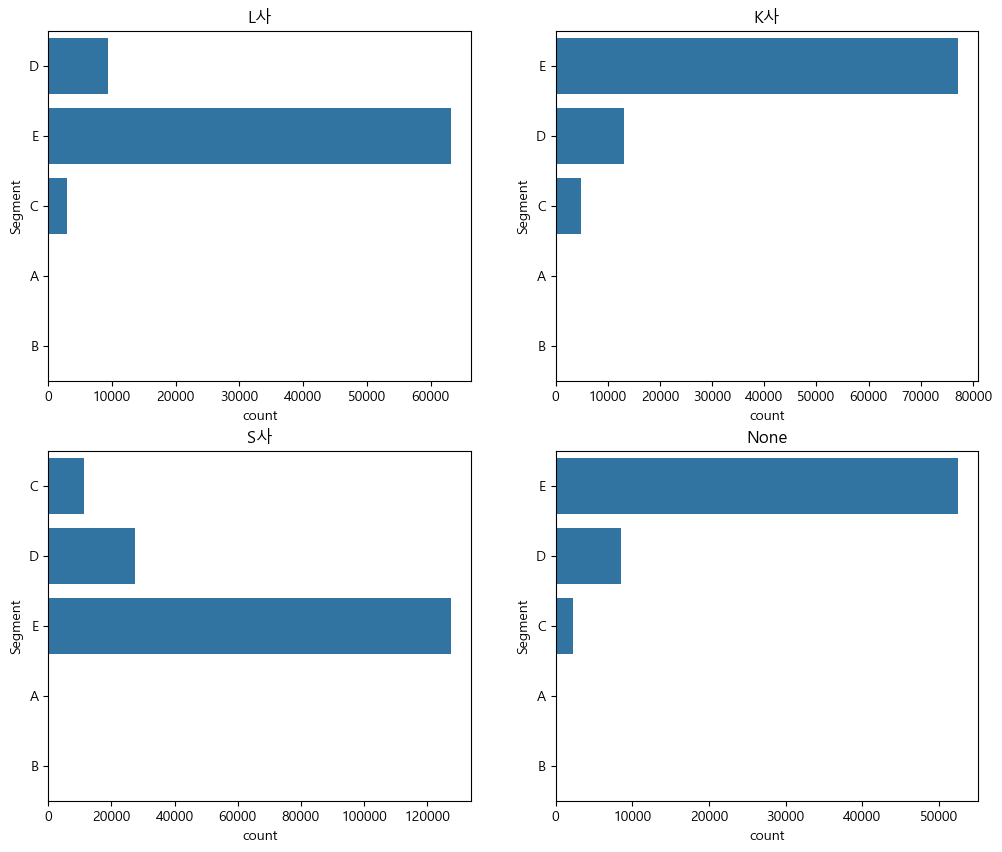

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
for i, code in enumerate(X_cat['가입통신회사코드'].unique()):
    if code == None:
        sns.countplot(customer_train_df.loc[customer_train_df['가입통신회사코드'].isnull(), "Segment"], ax=ax[i//2, i%2])
        ax[i//2, i%2].set_title("None")
        continue
    sns.countplot(customer_train_df.loc[customer_train_df['가입통신회사코드'] == code, "Segment"], ax=ax[i//2, i%2])
    ax[i//2, i%2].set_title(code)
    

- 결측치 `None`으로 대체

In [30]:
X_cat_filled["직장시도명"] = X_cat_filled["직장시도명"].fillna("None")

<Axes: xlabel='count', ylabel='Segment'>

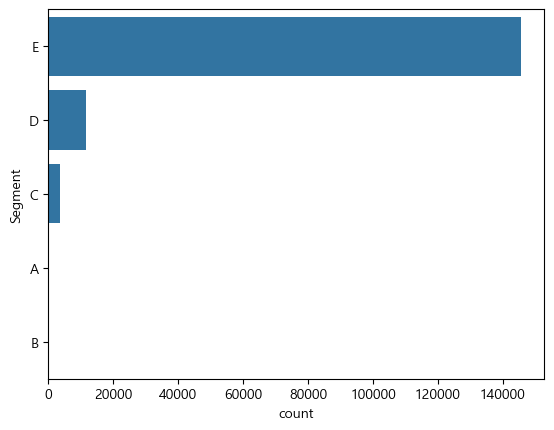

In [31]:
sns.countplot(customer_train_df.loc[customer_train_df._2순위신용체크구분.isnull(), "Segment"])

<Axes: xlabel='count', ylabel='Segment'>

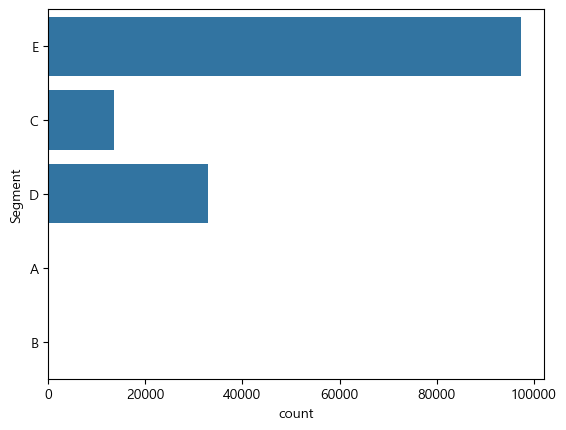

In [32]:
sns.countplot(customer_train_df.loc[customer_train_df._2순위신용체크구분 == "신용", "Segment"])

<Axes: xlabel='count', ylabel='Segment'>

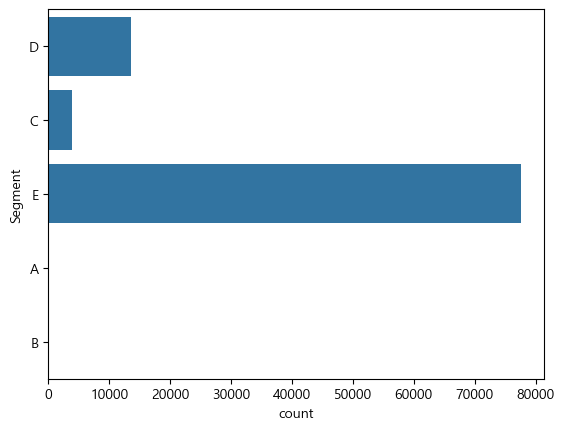

In [33]:
sns.countplot(customer_train_df.loc[customer_train_df._2순위신용체크구분 == "체크", "Segment"])

In [34]:
X_cat_filled = X_cat_filled.drop(columns=["_2순위신용체크구분"])
X_cat_filled

,남녀구분코드,연령,회원여부_이용가능,회원여부_이용가능_CA,회원여부_이용가능_카드론,소지여부_신용,소지카드수_유효_신용,소지카드수_이용가능_신용,회원여부_연체,이용거절여부_카드론,...,_1순위신용체크구분,보유여부_해외겸용_본인,이용가능여부_해외겸용_본인,이용여부_3M_해외겸용_본인,보유여부_해외겸용_신용_본인,이용가능여부_해외겸용_신용_본인,이용여부_3M_해외겸용_신용_본인,연회비발생카드수_B0M,카드신청건수,Life_Stage
0,2,40대,1,1,0,1,1,1,0,0,...,신용,0,0,0,0,0,0,0개,0,자녀성장(2)
1,1,30대,1,1,1,1,1,1,0,0,...,신용,0,0,0,0,0,0,0개,0,자녀성장(1)
2,1,30대,1,1,0,1,1,1,0,0,...,신용,1,1,0,0,0,0,0개,0,자녀출산기
3,2,40대,1,1,0,1,2,2,0,0,...,신용,1,1,1,1,1,1,0개,1,자녀성장(2)
4,2,40대,1,1,1,1,1,1,0,0,...,신용,1,1,1,0,0,0,0개,0,자녀성장(1)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,2,70대이상,1,1,1,1,1,1,0,0,...,신용,1,1,1,1,1,0,0개,0,노년생활
399996,2,50대,1,1,1,1,1,1,0,0,...,신용,1,1,1,1,1,1,0개,0,자녀성장(2)
399997,1,30대,1,1,0,1,1,1,0,0,...,신용,1,1,1,1,1,1,0개,0,자녀출산기
399998,1,40대,1,1,1,1,1,1,0,0,...,신용,0,0,0,0,0,0,0개,0,자녀성장(1)


In [35]:
X_cat_filled.columns

Index(['남녀구분코드', '연령', '회원여부_이용가능', '회원여부_이용가능_CA', '회원여부_이용가능_카드론', '소지여부_신용',
       '소지카드수_유효_신용', '소지카드수_이용가능_신용', '회원여부_연체', '이용거절여부_카드론', '동의여부_한도증액안내',
       '수신거부여부_TM', '수신거부여부_DM', '수신거부여부_메일', '수신거부여부_SMS', '가입통신회사코드',
       '탈회횟수_누적', '탈회횟수_발급6개월이내', '탈회횟수_발급1년이내', '거주시도명', '직장시도명', '마케팅동의여부',
       '유효카드수_신용체크', '유효카드수_신용', '유효카드수_신용_가족', '유효카드수_체크', '이용가능카드수_신용체크',
       '이용가능카드수_신용', '이용가능카드수_신용_가족', '이용가능카드수_체크', '이용카드수_신용체크', '이용카드수_신용',
       '이용카드수_신용_가족', '이용카드수_체크', '_1순위신용체크구분', '보유여부_해외겸용_본인',
       '이용가능여부_해외겸용_본인', '이용여부_3M_해외겸용_본인', '보유여부_해외겸용_신용_본인',
       '이용가능여부_해외겸용_신용_본인', '이용여부_3M_해외겸용_신용_본인', '연회비발생카드수_B0M', '카드신청건수',
       'Life_Stage'],
      dtype='object')

#### 범주형 데이터 다음에 할 것
- 명목척도 - 다중 클래스 인코딩
- 서열척도 - 레이블 인코딩

In [36]:
binary = [] ## 단순 레이블 인코딩할거임
not_binary = [] ## 순서가 의미가 없는 변수에 한해서 다중 클래스 인코딩, 나머지 서열척도는 레이블 인코딩 진행예정

for col in X_cat_filled.columns:
    print(col)
    print(X_cat_filled[col].unique())
    print()
    if len(X_cat_filled[col].unique()) == 2:
        binary.append(col)
    else:
        not_binary.append(col)
print("binary:", binary, len(binary))
print("not binary:", not_binary, len(not_binary))

남녀구분코드
[2 1]

연령
['40대' '30대' '20대' '60대' '50대' '70대이상']

회원여부_이용가능
[1 0]

회원여부_이용가능_CA
[1 0]

회원여부_이용가능_카드론
[0 1]

소지여부_신용
[1 0]

소지카드수_유효_신용
[1 2 3 0 4]

소지카드수_이용가능_신용
[1 2 3 0]

회원여부_연체
[0 1]

이용거절여부_카드론
[0 1]

동의여부_한도증액안내
[1 0]

수신거부여부_TM
[0 1]

수신거부여부_DM
[0 1]

수신거부여부_메일
[0 1]

수신거부여부_SMS
[0 1]

가입통신회사코드
['L사' 'K사' 'S사' None]

탈회횟수_누적
[1 0 2]

탈회횟수_발급6개월이내
[0 1]

탈회횟수_발급1년이내
[0 1]

거주시도명
['서울' '경기' '부산' '대전' '대구' '인천' '경남' '광주' '충북' '전남' '울산' '경북' '강원' '전북'
 '제주' '충남' '세종']

직장시도명
['서울' '경기' '부산' '강원' '대전' 'None' '인천' '경남' '광주' '충북' '전남' '경북' '울산' '전북'
 '세종' '대구' '충남' '제주']

마케팅동의여부
[1 0]

유효카드수_신용체크
[2 1 3 7 5 0 4 6 8]

유효카드수_신용
[1 2 3 4 0 5]

유효카드수_신용_가족
[0 1 2]

유효카드수_체크
[1 0 3 2]

이용가능카드수_신용체크
[2 1 3 7 5 0 4 6 8]

이용가능카드수_신용
[1 2 3 4 0 5]

이용가능카드수_신용_가족
[0 1 2]

이용가능카드수_체크
[1 0 3 2]

이용카드수_신용체크
[1 0 2 5 3 4 6]

이용카드수_신용
[1 0 2 4 3 5]

이용카드수_신용_가족
[0 1 2]

이용카드수_체크
[0 1 2]

_1순위신용체크구분
['신용' '체크']

보유여부_해외겸용_본인
[0 1]

이용가능여부_해외겸용_본인
[0 1]

이용여부_3M_해외겸용_본인
[0 1]

보유여부_해외겸용_신용_본인


In [37]:
X_cat_encoded = X_cat_filled.copy()

In [38]:
## not binary

In [39]:
for col in not_binary:
    print(col)
    print(X_cat_filled[col].unique())
    print()

연령
['40대' '30대' '20대' '60대' '50대' '70대이상']

소지카드수_유효_신용
[1 2 3 0 4]

소지카드수_이용가능_신용
[1 2 3 0]

가입통신회사코드
['L사' 'K사' 'S사' None]

탈회횟수_누적
[1 0 2]

거주시도명
['서울' '경기' '부산' '대전' '대구' '인천' '경남' '광주' '충북' '전남' '울산' '경북' '강원' '전북'
 '제주' '충남' '세종']

직장시도명
['서울' '경기' '부산' '강원' '대전' 'None' '인천' '경남' '광주' '충북' '전남' '경북' '울산' '전북'
 '세종' '대구' '충남' '제주']

유효카드수_신용체크
[2 1 3 7 5 0 4 6 8]

유효카드수_신용
[1 2 3 4 0 5]

유효카드수_신용_가족
[0 1 2]

유효카드수_체크
[1 0 3 2]

이용가능카드수_신용체크
[2 1 3 7 5 0 4 6 8]

이용가능카드수_신용
[1 2 3 4 0 5]

이용가능카드수_신용_가족
[0 1 2]

이용가능카드수_체크
[1 0 3 2]

이용카드수_신용체크
[1 0 2 5 3 4 6]

이용카드수_신용
[1 0 2 4 3 5]

이용카드수_신용_가족
[0 1 2]

이용카드수_체크
[0 1 2]

Life_Stage
['자녀성장(2)' '자녀성장(1)' '자녀출산기' '독신' '노년생활' '가족구축기' '자녀독립기']



In [40]:
## 인코딩이 필요한(=문자열인) 서열척도
ordinal_scale = ["연령", "Life_Stage"]

## 인코딩이 필요한(=문자열인) 명목척도
nominal_scale = ["가입통신회사코드", "거주시도명", "직장시도명"]

In [41]:
## 명목척도
## 원 핫 인코딩 적용 클래스 50개 미만까지는 성능 보장 (**추후에 다중 타겟 인코딩 적용해보기**)

X_cat_encoded = pd.get_dummies(X_cat_encoded, columns=['직장시도명'], drop_first=True)
X_cat_encoded = pd.get_dummies(X_cat_encoded, columns=['거주시도명'], drop_first=True)
X_cat_encoded = pd.get_dummies(X_cat_encoded, columns=['가입통신회사코드'], drop_first=True)

In [42]:
age_map = {
    '20대': 0,
    '30대': 1,
    '40대': 2,
    '50대': 3,
    '60대': 4,
    '70대이상': 5
}

life_stage_map = {
    "독신": 0,
    "가족구축기": 1,
    "자녀출산기": 2,
    "자녀성장(1)": 3,
    "자녀성장(2)": 4,
    "자녀독립기": 5, 
    "노년생활": 6
}

X_cat_encoded['연령'] = X_cat_filled['연령'].map(age_map)
X_cat_encoded['Life_Stage'] = X_cat_filled['Life_Stage'].map(life_stage_map)

In [43]:
## binary
## 남녀구분코드만 0이랑 1로 교체
X_cat_filled["남녀구분코드"] -= 1
X_cat_filled["남녀구분코드"].unique()
## _1순위신용체크구분, 연회비발생카드수_B0M
credit_check_map = {
    '신용': 0, 
    '체크': 1
}

card_count_B0M_map  = {
    '0개': 0, 
    '1개이상': 1
}

X_cat_encoded['_1순위신용체크구분'] = X_cat_filled['_1순위신용체크구분'].map(credit_check_map)
X_cat_encoded['연회비발생카드수_B0M'] = X_cat_filled['연회비발생카드수_B0M'].map(card_count_B0M_map)

In [44]:
X_cat_encoded = X_cat_encoded.astype(int)
X_cat_encoded

,남녀구분코드,연령,회원여부_이용가능,회원여부_이용가능_CA,회원여부_이용가능_카드론,소지여부_신용,소지카드수_유효_신용,소지카드수_이용가능_신용,회원여부_연체,이용거절여부_카드론,...,거주시도명_세종,거주시도명_울산,거주시도명_인천,거주시도명_전남,거주시도명_전북,거주시도명_제주,거주시도명_충남,거주시도명_충북,가입통신회사코드_L사,가입통신회사코드_S사
0,2,2,1,1,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,1,1,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2,2,1,1,0,1,2,2,0,0,...,0,0,0,0,0,0,0,0,1,0
4,2,2,1,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,2,5,1,1,1,1,1,1,0,0,...,0,0,1,0,0,0,0,0,0,1
399996,2,3,1,1,1,1,1,1,0,0,...,0,0,1,0,0,0,0,0,1,0
399997,1,1,1,1,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
399998,1,2,1,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


# Continous features

In [45]:
from scipy import stats

valid_con_cols = []

for col in continuous_cols:
    groups = []
    for segment in customer_train_df['Segment'].unique():
        groups.append(customer_train_df[~(customer_train_df[col].isnull()) & (customer_train_df['Segment'] == segment)][col])
    
    # 3. 일원 분산분석 (One-way ANOVA) 실행
    # f_oneway는 그룹별 데이터 리스트를 인수로 받습니다.
    f_statistic, p_value = stats.f_oneway(*groups)
    
    # 4. 결과 출력
    print(customer_train_df.groupby('Segment')[col].mean().to_markdown(floatfmt=".2f"))
    
    print("\n--- 일원 분산분석 (ANOVA) 결과 ---")
    print(f"F-통계량: {f_statistic:.4f}")
    print(f"P-값: {p_value:.4e}") # P-값을 과학적 표기법으로 출력
    if p_value < 0.05:
        valid_con_cols.append(col)
    print()

| Segment   |   입회일자_신용 |
|:----------|----------------:|
| A         |     20015616.43 |
| B         |     20075996.83 |
| C         |     20073454.41 |
| D         |     20102220.37 |
| E         |     20129595.31 |

--- 일원 분산분석 (ANOVA) 결과 ---
F-통계량: 6800.6140
P-값: 0.0000e+00

| Segment   |   입회경과개월수_신용 |
|:----------|----------------------:|
| A         |                203.30 |
| B         |                131.71 |
| C         |                134.11 |
| D         |                 99.63 |
| E         |                 66.87 |

--- 일원 분산분석 (ANOVA) 결과 ---
F-통계량: 6800.8643
P-값: 0.0000e+00

| Segment   |   최종탈회후경과월 |
|:----------|-------------------:|
| A         |              22.41 |
| B         |              37.62 |
| C         |              27.42 |
| D         |              27.83 |
| E         |              27.85 |

--- 일원 분산분석 (ANOVA) 결과 ---
F-통계량: 1.7902
P-값: 1.2763e-01

| Segment   |   이용금액_R3M_신용체크 |
|:----------|------------------------:|
| A         |                9827

In [46]:
print(len(continuous_cols))
print(len(valid_con_cols))

19
14


In [47]:
X_con = X[valid_con_cols]
missing_percentage = (X_con.isnull().sum() / len(X_con)) * 100

print("--- 훈련 데이터 컬럼별 결측치 비율 (%) ---")
print(missing_percentage[missing_percentage>0])

--- 훈련 데이터 컬럼별 결측치 비율 (%) ---
최종유효년월_신용_이용가능     9.15225
최종유효년월_신용_이용      23.20175
최종카드발급일자           2.37375
dtype: float64


In [48]:
missing_percentage = (customer_test_df[valid_con_cols].isnull().sum() / len(customer_test_df[valid_con_cols])) * 100

print("---  데이터 컬럼별 결측치 비율 (%) ---")
print(missing_percentage[missing_percentage>0])

---  데이터 컬럼별 결측치 비율 (%) ---
최종유효년월_신용_이용가능     9.349
최종유효년월_신용_이용      23.043
최종카드발급일자           2.755
dtype: float64


### 최종카드발급일자(2.37375%)

In [49]:
X_con_filled = X_con.copy()

<Axes: xlabel='최종카드발급일자', ylabel='Count'>

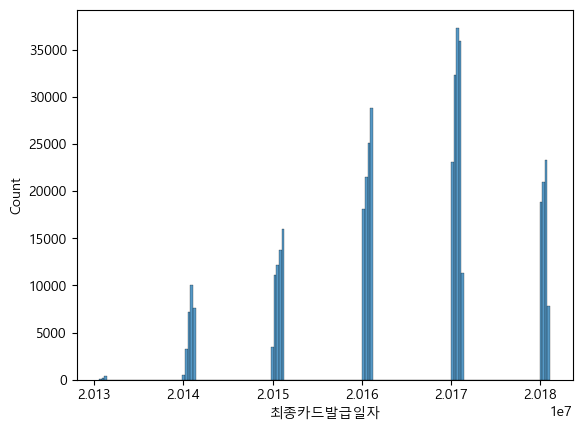

In [50]:
sns.histplot(X_con['최종카드발급일자'])

In [51]:
X_con['최종카드발급일자'].median()

20170217.0

결측치 최빈값으로 대체

In [52]:
X_con_filled.loc[X_con_filled['최종카드발급일자'].isnull(), '최종카드발급일자'] = X_con['최종카드발급일자'].median()

### 최종유효년월_신용_이용가능(9.15225%)

<Axes: xlabel='최종유효년월_신용_이용가능', ylabel='Count'>

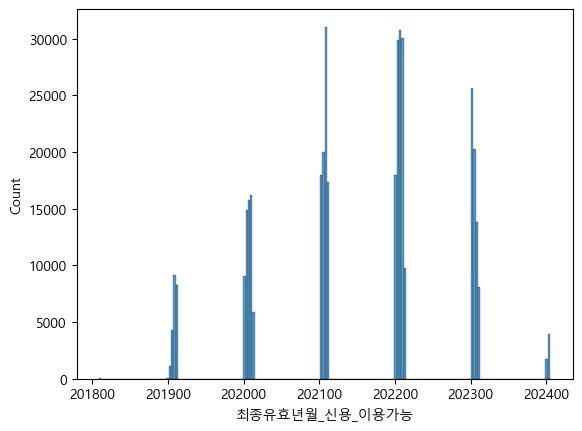

In [53]:
sns.histplot(X_con['최종유효년월_신용_이용가능'])

In [54]:
X_con['최종유효년월_신용_이용가능']

0         202106.0
1         202112.0
2         202103.0
3         202207.0
4         202208.0
            ...   
399995    202105.0
399996    202106.0
399997    202106.0
399998    202203.0
399999    202211.0
Name: 최종유효년월_신용_이용가능, Length: 400000, dtype: float64

A ratio: 0.0
B ratio: 0.0

A ratio: 0.0004348771472059143
B ratio: 0.0

A ratio: 0.0004686565716963752
B ratio: 9.696342862683624e-05

A ratio: 0.000497362820394189
B ratio: 8.096604052928658e-05

A ratio: 0.00047255390067929624
B ratio: 6.750770009704231e-05

A ratio: 0.00030971624092973864
B ratio: 4.4245177275676954e-05

A ratio: 0.0005272407732864675
B ratio: 0.0



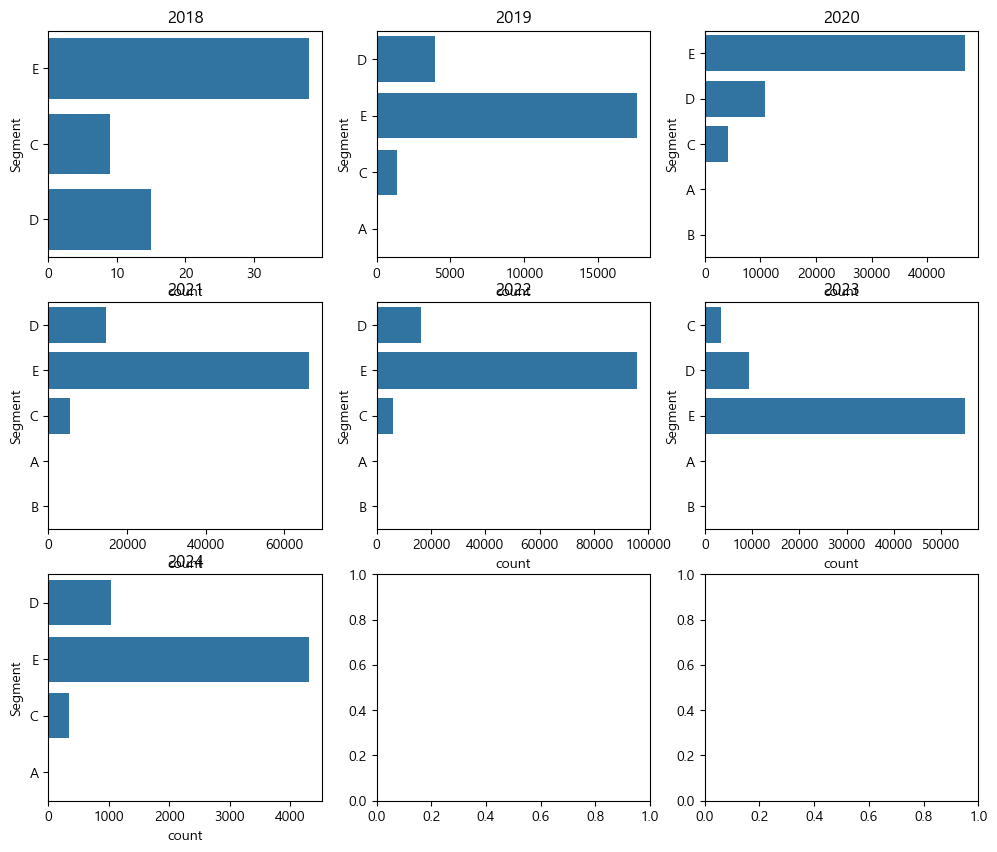

In [55]:
fig, ax = plt.subplots(3, 3, figsize=(12, 10))
for i in range(7):
    sns.countplot(customer_train_df.loc[customer_train_df['최종유효년월_신용_이용가능']//100 == 2018+i, "Segment"], ax = ax[i//3, i%3])
    ax[i//3, i%3].set_title(2018+i)
    print("A ratio:", len(customer_train_df.loc[(customer_train_df['최종유효년월_신용_이용가능']//100 == 2018+i) & (customer_train_df['Segment'] == "A")])/len(customer_train_df.loc[customer_train_df['최종유효년월_신용_이용가능']//100 == 2018+i, "Segment"]))
    print("B ratio:", len(customer_train_df.loc[(customer_train_df['최종유효년월_신용_이용가능']//100 == 2018+i) & (customer_train_df['Segment'] == "B")])/len(customer_train_df.loc[customer_train_df['최종유효년월_신용_이용가능']//100 == 2018+i, "Segment"]))
    print()

- 결측치는 중앙값(median)으로 대체
- 새로운 피처를 생성해서 결측치였던 위치를 표시(결측치 비율이 매우 낮은 경우는 해당안함)

In [56]:
X_con_filled["최종유효년월_신용_이용가능_nan"] = 0
X_con_filled.loc[X_con["최종유효년월_신용_이용가능"].isnull(), "최종유효년월_신용_이용가능_nan"] = 1
X_con_filled.loc[X_con["최종유효년월_신용_이용가능"].isnull(), "최종유효년월_신용_이용가능"] = X_con["최종유효년월_신용_이용가능"].median()

### 최종유효년월_신용_이용(23.20175%)

A ratio: 0.0
B ratio: 0.0

A ratio: 0.00030441400304414006
B ratio: 0.0

A ratio: 0.0004686565716963752
B ratio: 0.00011312400006464228

A ratio: 0.0006477283242342926
B ratio: 6.939946331081706e-05

A ratio: 0.00043880005063077506
B ratio: 8.43846251213029e-05

A ratio: 0.00022122588637838475
B ratio: 1.474839242522565e-05

A ratio: 0.000351493848857645
B ratio: 0.0



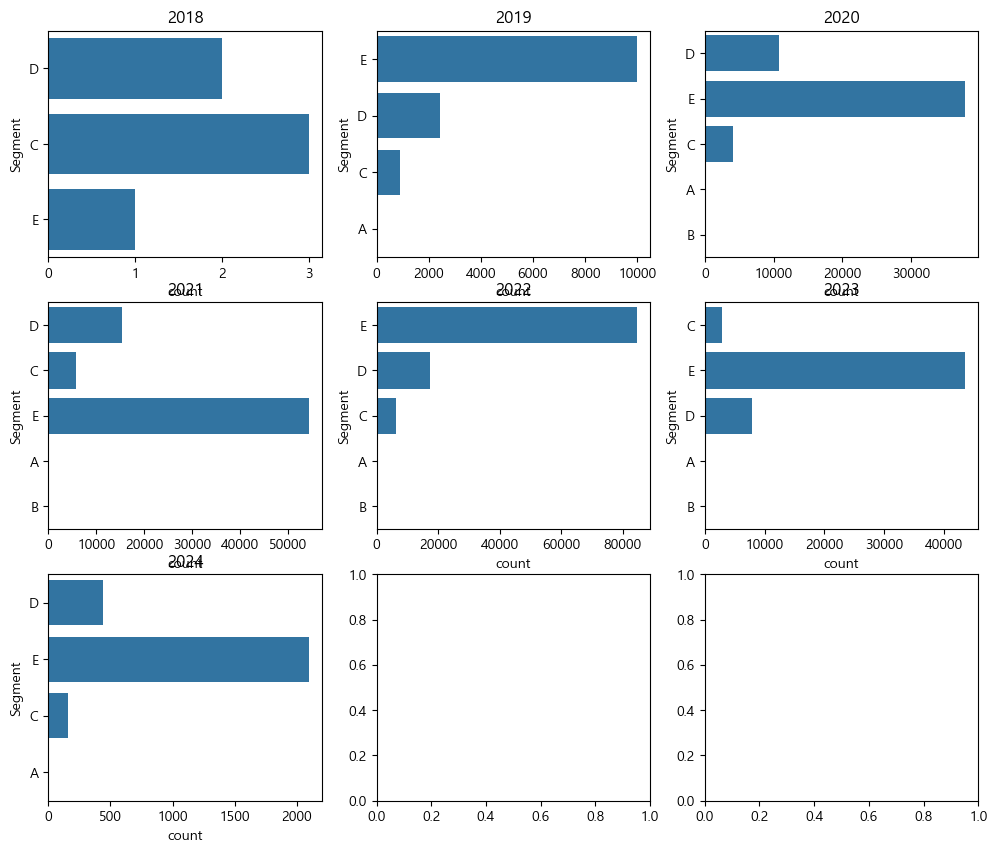

In [57]:
fig, ax = plt.subplots(3, 3, figsize=(12, 10))
for i in range(7):
    sns.countplot(customer_train_df.loc[customer_train_df['최종유효년월_신용_이용']//100 == 2018+i, "Segment"], ax = ax[i//3, i%3])
    ax[i//3, i%3].set_title(2018+i)
    print("A ratio:", len(customer_train_df.loc[(customer_train_df['최종유효년월_신용_이용']//100 == 2018+i) & (customer_train_df['Segment'] == "A")])/len(customer_train_df.loc[customer_train_df['최종유효년월_신용_이용가능']//100 == 2018+i, "Segment"]))
    print("B ratio:", len(customer_train_df.loc[(customer_train_df['최종유효년월_신용_이용']//100 == 2018+i) & (customer_train_df['Segment'] == "B")])/len(customer_train_df.loc[customer_train_df['최종유효년월_신용_이용가능']//100 == 2018+i, "Segment"]))
    print()

- 결측치는 중앙값(median)으로 대체
- 새로운 피처를 생성해서 결측치였던 위치를 표시(결측치 비율이 매우 낮은 경우는 해당안함)

In [58]:
X_con_filled["최종유효년월_신용_이용_nan"] = 0
X_con_filled.loc[X_con["최종유효년월_신용_이용"].isnull(), "최종유효년월_신용_이용_nan"] = 1
X_con_filled.loc[X_con["최종유효년월_신용_이용"].isnull(), "최종유효년월_신용_이용"] = X_con["최종유효년월_신용_이용"].median()

In [59]:
X_con_filled

,입회일자_신용,입회경과개월수_신용,이용금액_R3M_신용체크,이용금액_R3M_신용,이용금액_R3M_신용_가족,이용금액_R3M_체크,_1순위카드이용금액,_1순위카드이용건수,_2순위카드이용금액,_2순위카드이용건수,최종유효년월_신용_이용가능,최종유효년월_신용_이용,최종카드발급일자,최종카드발급경과월,최종유효년월_신용_이용가능_nan,최종유효년월_신용_이용_nan
0,20130101,71,-478,-478,0,0,3048,26,0,0,202106.0,202108.0,20160912.0,26,0,0
1,20170801,16,7276,7276,0,0,6719,33,0,0,202112.0,202202.0,20170122.0,22,0,0
2,20080401,128,17678,17678,0,0,19346,43,0,0,202103.0,202108.0,20161113.0,24,0,0
3,20160501,31,2942,2942,0,0,5782,9,0,0,202207.0,202201.0,20170205.0,21,0,0
4,20180601,6,2706,0,0,2706,0,-2,0,0,202208.0,202202.0,20170409.0,19,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,20010701,209,2652,0,0,2652,0,-2,0,0,202105.0,202202.0,20150902.0,38,0,1
399996,20170701,17,26879,26879,0,0,26844,49,0,0,202106.0,202107.0,20161201.0,23,0,0
399997,20090501,115,22498,22498,0,0,20206,32,0,0,202106.0,202104.0,20170609.0,17,0,0
399998,20130101,71,0,0,0,0,0,-2,0,0,202203.0,202202.0,20160928.0,26,0,1


In [60]:
X_con_filled.columns

Index(['입회일자_신용', '입회경과개월수_신용', '이용금액_R3M_신용체크', '이용금액_R3M_신용',
       '이용금액_R3M_신용_가족', '이용금액_R3M_체크', '_1순위카드이용금액', '_1순위카드이용건수',
       '_2순위카드이용금액', '_2순위카드이용건수', '최종유효년월_신용_이용가능', '최종유효년월_신용_이용',
       '최종카드발급일자', '최종카드발급경과월', '최종유효년월_신용_이용가능_nan', '최종유효년월_신용_이용_nan'],
      dtype='object')

In [61]:
X_con_norm = X_con_filled.copy()

In [62]:
len(X_con_filled.최종카드발급일자.unique())

1908

In [63]:
len(X_con_filled.최종카드발급경과월.unique())

66

In [64]:
len((X_con_filled.최종카드발급일자//100).unique())

66

- 입회일자_신용 : 입회경과개월수_신용과 같음 -> drop
- 최종카드발급일자 : 최종카드발급경과월과 같음 -> drop

In [65]:
X_con_norm = X_con_norm.drop(columns=["입회일자_신용", "최종카드발급일자"])

In [66]:
X_con_norm.columns

Index(['입회경과개월수_신용', '이용금액_R3M_신용체크', '이용금액_R3M_신용', '이용금액_R3M_신용_가족',
       '이용금액_R3M_체크', '_1순위카드이용금액', '_1순위카드이용건수', '_2순위카드이용금액', '_2순위카드이용건수',
       '최종유효년월_신용_이용가능', '최종유효년월_신용_이용', '최종카드발급경과월', '최종유효년월_신용_이용가능_nan',
       '최종유효년월_신용_이용_nan'],
      dtype='object')

### 입회경과개월수_신용

<Axes: xlabel='입회경과개월수_신용', ylabel='Count'>

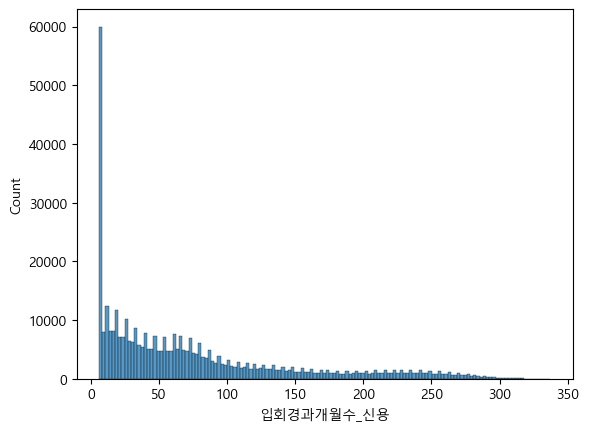

In [67]:
sns.histplot(X_con_filled["입회경과개월수_신용"])

In [68]:
X_con_filled["입회경과개월수_신용"].min()

6

<Axes: xlabel='입회경과개월수_신용', ylabel='Count'>

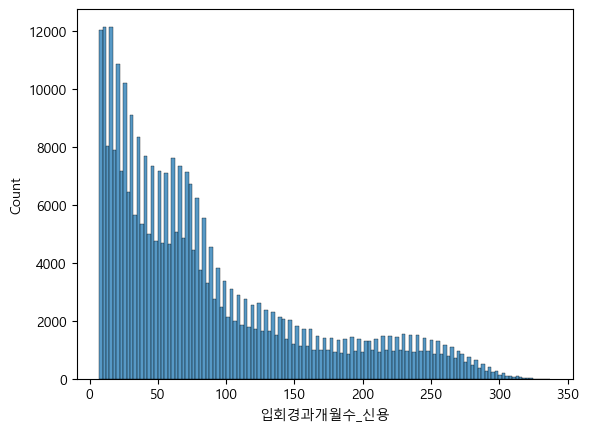

In [69]:
sns.histplot(X_con_filled.loc[X_con_filled["입회경과개월수_신용"] > 6, "입회경과개월수_신용"])

<Axes: xlabel='Segment', ylabel='Count'>

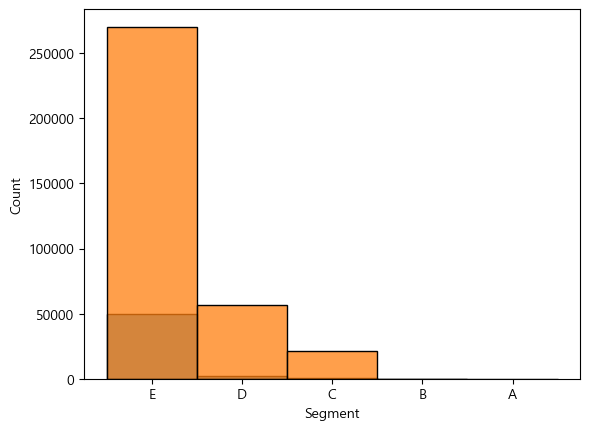

In [70]:
sns.histplot(customer_train_df.loc[customer_train_df["입회경과개월수_신용"] == 6, "Segment"])
sns.histplot(customer_train_df.loc[customer_train_df["입회경과개월수_신용"] > 6, "Segment"])

데이터가 6에 몰려있으며, 6이 아닌 것들의 분포도 많이 왜곡되어 있음 -> 값이 6인지 확인하는 피처 추가 및 기존 피처 로그변환

Text(0.5, 1.0, '로그변환 후')

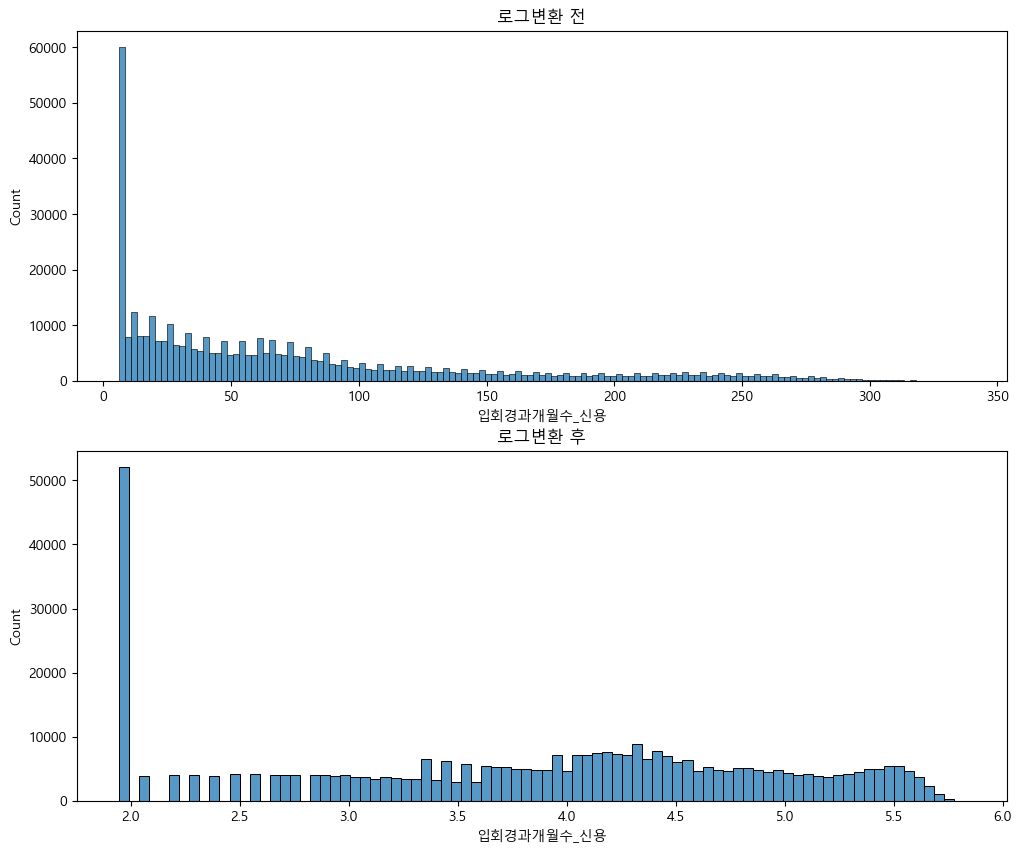

In [71]:
fig, ax = plt.subplots(2, figsize=(12, 10))
sns.histplot(X_con_filled["입회경과개월수_신용"], ax=ax[0])
ax[0].set_title("로그변환 전")

sns.histplot(np.log1p(X_con_filled["입회경과개월수_신용"]), ax=ax[1])
ax[1].set_title("로그변환 후")

In [72]:
X_con_norm['입회경과개월수_신용_6'] = 0
X_con_norm.loc[X_con_norm['입회경과개월수_신용'] == 6, "입회경과개월수_신용_6"] = 1
X_con_norm["입회경과개월수_신용"] = np.log1p(X_con_filled["입회경과개월수_신용"])

### 이용금액_R3M_신용체크

<Axes: xlabel='이용금액_R3M_신용체크', ylabel='Count'>

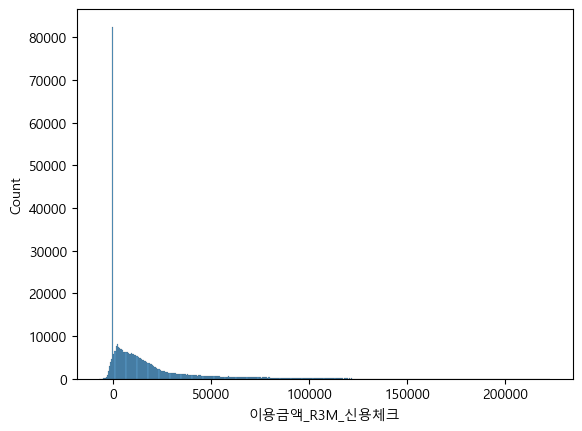

In [73]:
sns.histplot(X_con_filled["이용금액_R3M_신용체크"])

In [74]:
X_con_filled["이용금액_R3M_신용체크"].mode()

0    0
Name: 이용금액_R3M_신용체크, dtype: int64

0에 몰려있음

<Axes: xlabel='이용금액_R3M_신용체크', ylabel='Count'>

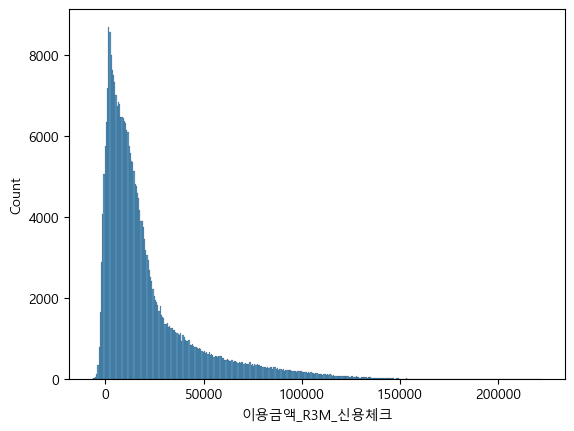

In [75]:
sns.histplot(X_con_filled.loc[X_con_filled["이용금액_R3M_신용체크"] != 0, "이용금액_R3M_신용체크"])

0이 아닌 다른 값들의 분포를 봤을때 마찬가지로 많이 왜곡되어 있음을 알 수 있음 -> 로그변환

<Axes: xlabel='count', ylabel='Segment'>

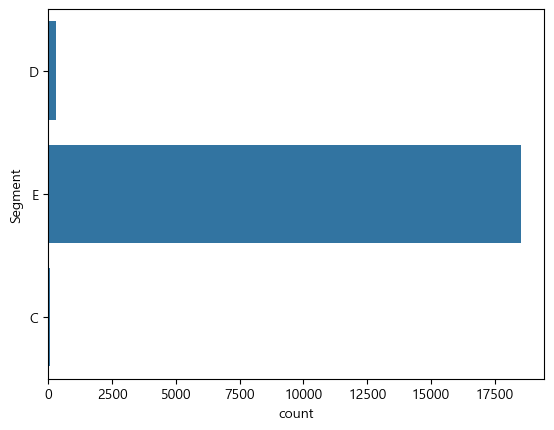

In [76]:
sns.countplot(customer_train_df.loc[customer_train_df["이용금액_R3M_신용체크"] < 0, "Segment"])

0
1


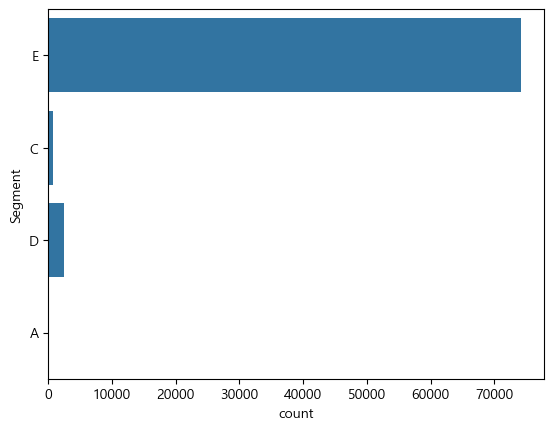

In [77]:
sns.countplot(customer_train_df.loc[customer_train_df["이용금액_R3M_신용체크"] == 0, "Segment"])
print(len(customer_train_df.loc[(customer_train_df["이용금액_R3M_신용체크"] == 0) & (customer_train_df["Segment"] == 'A')])//len(customer_train_df.loc[customer_train_df["이용금액_R3M_신용체크"] == 0]))
print(len(customer_train_df.loc[(customer_train_df["이용금액_R3M_신용체크"] == 0) & (customer_train_df["Segment"] == 'A')]))

값이 0이하인 경우 A, B 비율이 0에 수렴함 -> 어차피 로그변환도 해야하기 때문에 음수값도 0으로 대체

In [78]:
X_con_norm.loc[X_con_norm['이용금액_R3M_신용체크'] <= 0, '이용금액_R3M_신용체크'] = 0

<Axes: xlabel='이용금액_R3M_신용체크', ylabel='Count'>

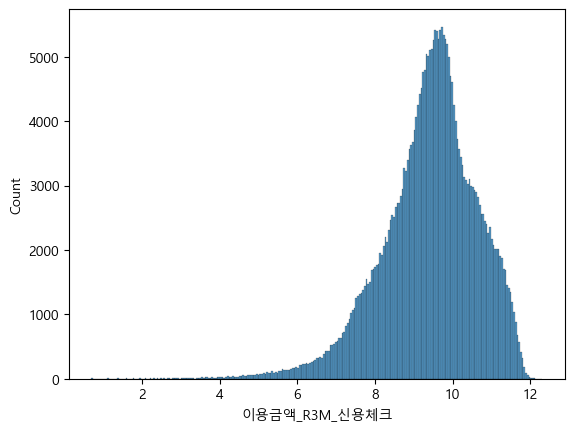

In [79]:
sns.histplot(np.log1p(X_con_norm.loc[X_con_norm["이용금액_R3M_신용체크"] != 0, "이용금액_R3M_신용체크"]))

비교적 완만해짐 그리고 종 모양에 가까워짐

In [80]:
X_con_norm["이용금액_R3M_신용체크_0"] = 0
X_con_norm.loc[X_con_norm["이용금액_R3M_신용체크"] == 0, "이용금액_R3M_신용체크_0"] = 1
X_con_norm["이용금액_R3M_신용체크"] = np.log1p(X_con_norm["이용금액_R3M_신용체크"])

---
# 여기까지 분석함

### 이용금액_R3M_신용

<Axes: xlabel='이용금액_R3M_신용', ylabel='Count'>

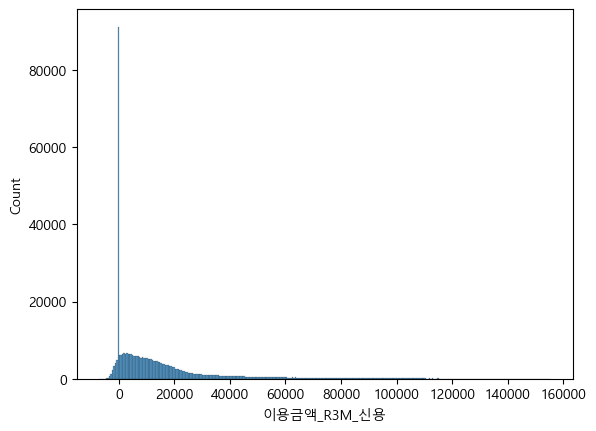

In [81]:
sns.histplot(X_con_filled["이용금액_R3M_신용"])

### 이용금액_R3M_신용_가족

<Axes: xlabel='이용금액_R3M_신용_가족', ylabel='Count'>

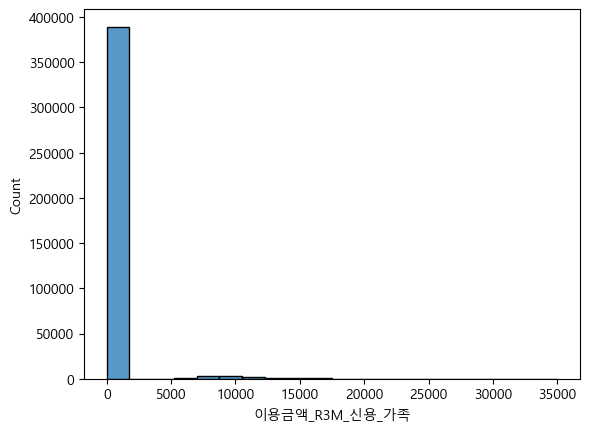

In [82]:
sns.histplot(X_con_filled["이용금액_R3M_신용_가족"])

### 이용금액_R3M_체크

<Axes: xlabel='이용금액_R3M_체크', ylabel='Count'>

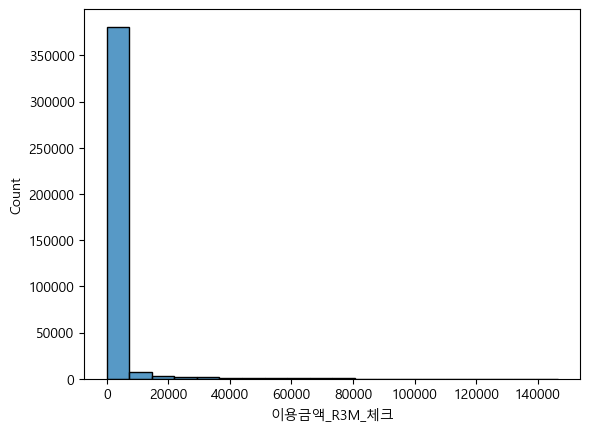

In [83]:
sns.histplot(X_con_filled["이용금액_R3M_체크"])

### _1순위카드이용금액

<Axes: xlabel='_1순위카드이용금액', ylabel='Count'>

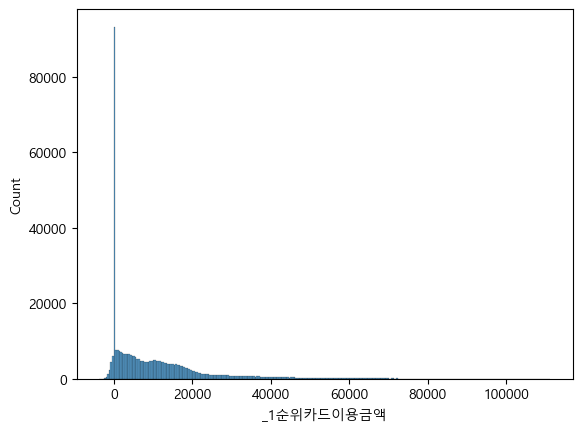

In [84]:
sns.histplot(X_con_filled["_1순위카드이용금액"])

### _2순위카드이용금액

<Axes: xlabel='_2순위카드이용금액', ylabel='Count'>

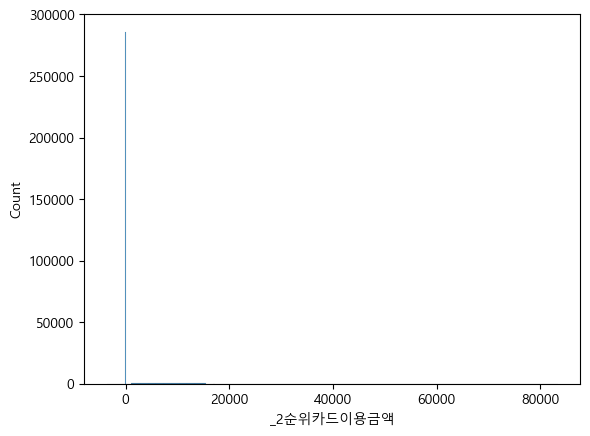

In [85]:
sns.histplot(X_con_filled["_2순위카드이용금액"])

### _2순위카드이용건수

<Axes: xlabel='_2순위카드이용건수', ylabel='Count'>

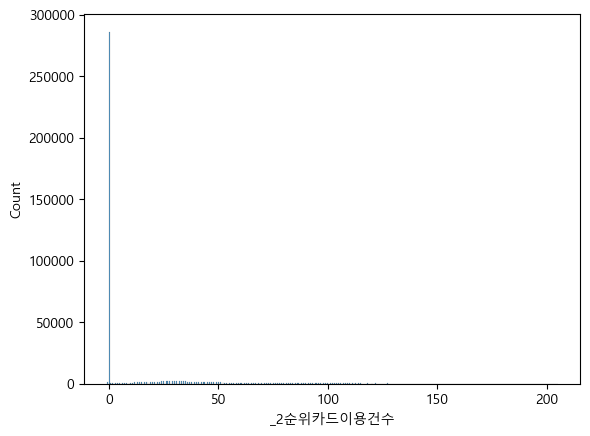

In [86]:
sns.histplot(X_con_filled["_2순위카드이용건수"])

### 최종유효년월_신용_이용가능

<Axes: xlabel='최종유효년월_신용_이용가능', ylabel='Count'>

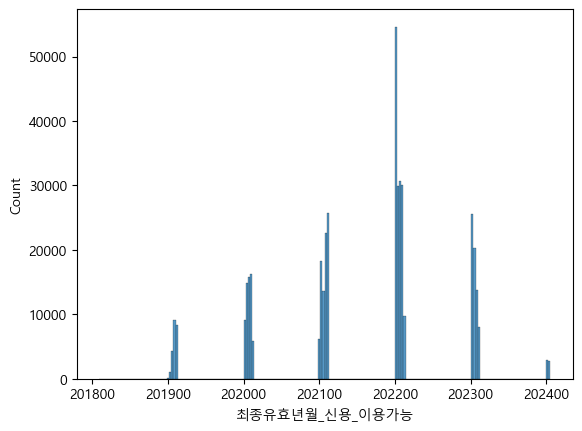

In [87]:
sns.histplot(X_con_filled["최종유효년월_신용_이용가능"])

### 최종유효년월_신용_이용

<Axes: xlabel='최종유효년월_신용_이용', ylabel='Count'>

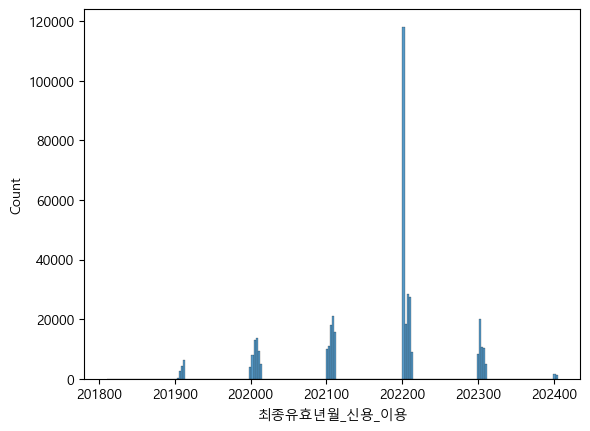

In [88]:
sns.histplot(X_con_filled["최종유효년월_신용_이용"])

### 최종카드발급경과월

<Axes: xlabel='최종카드발급경과월', ylabel='Count'>

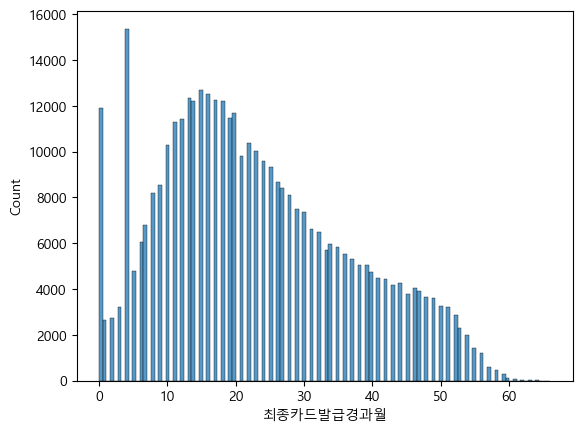

In [89]:
sns.histplot(X_con_filled.최종카드발급경과월)